In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

np.random.seed(0)
Gamma = 10

In [49]:
#load data
data = pd.read_excel('Welding_Data.xlsx') #using pandas to load the excel file
data = data.dropna(axis=0, how='any') #drop nan from the data

# prepare variables and target
X = data.loc[:,['Current','Angle','Speed']] #Variables, or using data.iloc[:,1:4]
Y = data.loc[:,'Height'] # Target
X = X.to_numpy() #conver data frame to numpy array
Y = Y.to_numpy()

# data normalization, normalization to [0 1] range
X_Norm = np.empty_like(X)
for i in range(X.shape[1]):
   data_ = X[:,i]
   X_Norm[:,i] = (data_-np.amin(data_))/(np.amax(data_)-np.amin(data_)) 
    
const = np.ones((len(X_Norm),1)) #constant colume
X_Norm = np.concatenate((X_Norm,const),axis = 1)
    
# normalize Y data
Y_Min = np.amin(Y)
Y_Max = np.amax(Y)
Y_Norm = (Y-Y_Min)/(Y_Max-Y_Min)


In [50]:
# prepare variables and target

index = np.arange(len(Y))
np.random.shuffle(index) #disorder the original data

m = np.ceil(0.7*len(Y)) # 70% for training and 30% for testing
m = int(m) #covert float type to int type
X_Train = X_Norm[index[:m]]
Y_Train = Y_Norm[index[:m]]

X_Test = X_Norm[index[m:]]
Y_Test = Y_Norm[index[m:]]

# X_Train_Kernel = X_Train
# X_Test_Kernel = X_Test

# kernel transformation
import sklearn.metrics.pairwise as pw
X_Train_Kernel = pw.rbf_kernel(X_Train, X_Train, gamma = Gamma)
X_Test_Kernel = pw.rbf_kernel(X_Test, X_Train, gamma = Gamma)

In [51]:
# define loss function, minimize the outlier tolerance and 1/2w2

def cost_function(X, Y, B, epsilon):
    J = np.mean(np.maximum(0, np.abs(Y - X.dot(B)) - epsilon)) + lamda * B.dot(B)/2  
    return J

In [52]:
# create iterative gradient descent training

def gradient_descent(X, Y, B, alpha, lamda, epsilon, iterations):
    cost_history = np.zeros(iterations)
    
    for iteration in range(iterations):
        
        loss = cost_function(X, Y, B, epsilon)
        
        gradient_ = np.zeros((len(X),X.shape[1]))
        for i in range(len(X)):
            if  np.abs(Y[i] - X[i].dot(B)) - epsilon > 0:
                gradient_[i] = X[i].T.dot(X[i].dot(B) - Y[i])/np.abs(Y[i] - X[i].dot(B))

        gradient = np.mean(gradient_,0) + lamda * B
        B = B - alpha * gradient
        cost_history[iteration] = loss
    
    return B, cost_history

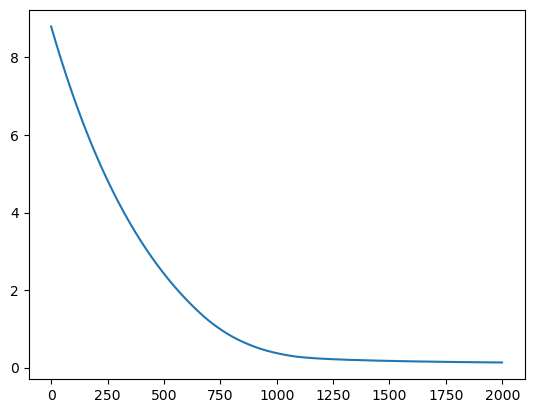

In [53]:
# training

B = np.random.random(X_Train_Kernel.shape[1]) # Initial Coefficients
alpha = 0.01 #learning rate
iter_ = 2000
lamda =  0.1 #1/iter_ #balancing coefficient
epsilon = 0.01
newB, cost_history = gradient_descent(X_Train_Kernel, Y_Train, B, alpha, lamda, epsilon, iter_)

plt.plot(np.arange(iter_), cost_history)


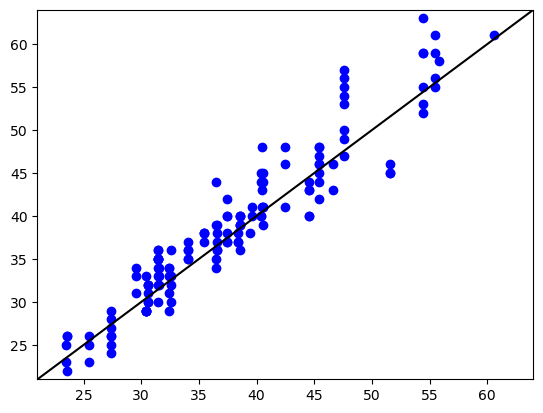

In [54]:
# testing 
y_predict = X_Test_Kernel.dot(newB)
y_predicted = y_predict * (Y_Max - Y_Min) + Y_Min
Y_Test = Y_Test * (Y_Max - Y_Min) + Y_Min
plt.scatter(y_predicted, Y_Test, c = 'b',marker = 'o')
plt.xlim(Y_Min, Y_Max)
plt.ylim(Y_Min, Y_Max)
plt.plot([Y_Min, Y_Max],[Y_Min, Y_Max],'k-')

In [55]:
# performance evaluation

def R2(Y,Y_pred):
    sst = np.sum((Y-Y.mean())**2)
    ssr = np.sum((Y-Y_pred)**2)
    R2 = 1-(ssr/sst)
    return R2

R2(Y_Test,y_predicted)

0.8886402373549502